In [3]:
# ! pip install gensim
# ! pip install nltk

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.dlpc.intranet/registry/repository/pypi/simple
     |████████████████████████████████| 1.4 MB 4.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=27a91ac01e4fce60de8789266ad12835088a09f6a20841fcf78d5c49b435beb1
  Stored in directory: /mnt/srv/home/dlpc.715/.cache/pip/wheels/88/ae/67/1a39cbb46b7b020a4cf3c813ee4c40ce23bc79bb89646ea82c
Successfully built nltk


출처 : https://wikidocs.net/50739

# 1. 영어 Word2Vec 만들기

In [ ]:
import nltk
nltk.download('punkt')

In [2]:
import urllib.request
import zipfile
from lxml import etree
import re
from nltk.tokenize import word_tokenize, sent_tokenize

## 1) 훈련 데이터 이해하기

In [3]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/GaoleMeng/RNN-and-FFNN-textClassification/master/ted_en-20160408.xml", 
                           filename="ted_en-20160408.xml")

('ted_en-20160408.xml', <http.client.HTTPMessage at 0x7f81b7a793c8>)

훈련 데이터 파일은 xml 문법으로 작성되어 있으므로 자연어를 얻으려면 전처리가 필요하다. 얻고자 하는 데이터는 영어문장으로만 구성된 내용을 담고 있는 content와 /content 사이의 내용이다. 전처리를 통해 xml 문법들은 제거하고 해당 데이터만 가져와야 한다. 뿐만 아니라 content와 /content 사이의 내용 중에는 배경음을 나타내는 단어도 제거해야 한다.

## 2) 훈련 데이터 전처리하기

In [9]:
targetXML=open('ted_en-20160408.xml', 'r', encoding='UTF8') # xml 파일 오픈
target_text = etree.parse(targetXML) # 오픈한 xml파일을 가져오기


# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.
parse_text = '\n'.join(target_text.xpath('//content/text()'))

# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.
content_text = re.sub(r'\([^)]*\)', '', parse_text)

# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.
sent_text = sent_tokenize(content_text)

# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.
normalized_text = []
for string in sent_text:
    tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
    normalized_text.append(tokens)

# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.
result = [word_tokenize(sentence) for sentence in normalized_text]

print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


In [10]:
for line in result[:3]:
    print(line)

['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


## 3) Word2Vec 훈련시키기

In [11]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.   
window = 컨텍스트 윈도우 크기   
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)   
workers = 학습을 위한 프로세스 수   
sg = 0은 CBOW, 1은 Skip-gram.   

In [12]:
model_result = model.wv.most_similar("man") # 입력한 단어("man")에 대해서 가장 유사한 단어들을 출력
print(model_result)

[('woman', 0.8511554002761841), ('guy', 0.7985062599182129), ('boy', 0.7883329391479492), ('lady', 0.7618979811668396), ('girl', 0.7314774990081787), ('gentleman', 0.7135226726531982), ('soldier', 0.7056684494018555), ('kid', 0.6884849071502686), ('poet', 0.6835141777992249), ('friend', 0.6589873433113098)]


## 4) Word2Vec 모델 저장하고 로드하기

In [13]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

In [14]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8511554002761841), ('guy', 0.7985062599182129), ('boy', 0.7883329391479492), ('lady', 0.7618979811668396), ('girl', 0.7314774990081787), ('gentleman', 0.7135226726531982), ('soldier', 0.7056684494018555), ('kid', 0.6884849071502686), ('poet', 0.6835141777992249), ('friend', 0.6589873433113098)]


# 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [16]:
# ! pip install konlpy

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: http://repo.dlpc.intranet/registry/repository/pypi/simple
     |████████████████████████████████| 19.4 MB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 23.5 MB/s eta 0:00:01


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f25e4ca7cf8>)

In [3]:
train_data = pd.read_table('ratings.txt')

In [4]:
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [5]:
# Null값 존재하는지 확인
print(train_data.isnull().values.any())

True


In [6]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [7]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [8]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [9]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [10]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [11]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


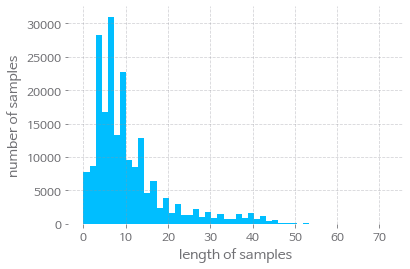

In [12]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [14]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [16]:
print(model.wv.most_similar("최민식"))

[('한석규', 0.8874288201332092), ('안성기', 0.8504939079284668), ('채민서', 0.850426197052002), ('김명민', 0.8498517274856567), ('박중훈', 0.8452017903327942), ('김수현', 0.8448143005371094), ('크로우', 0.8409170508384705), ('윤제문', 0.8403393030166626), ('서영희', 0.8396716117858887), ('설경구', 0.8387760519981384)]


In [17]:
print(model.wv.most_similar("히어로"))

[('느와르', 0.8777081966400146), ('무협', 0.8602524995803833), ('호러', 0.8437142968177795), ('슬래셔', 0.8264451622962952), ('물', 0.8156758546829224), ('블록버스터', 0.8121092319488525), ('홍콩', 0.8106405735015869), ('무비', 0.8089389801025391), ('물의', 0.7957336902618408), ('헐리우드', 0.7950146198272705)]


# 3. 한국어 Word2Vec 만들기(위키피디아)

## 1) 위키피디아 한국어 덤프 파일 다운로드   
https://dumps.wikimedia.org/kowiki/latest/



위 링크에는 많은 위키피디아 덤프 파일들이 존재한다. 그 중에서 사용할 데이터는 kowiki-latest-pages-articles.xml.bz2 파일. 해당 파일은 xml 파일므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있다.

## 2) 위키피디아 익스트랙터 다운로드   

해당 파일을 모두 다운로드 한 후 덤프 파일을 텍스트 형식으로 변환시켜주는 오픈소스인 '위키피디아 익스트랙터'를 사용할 것이다. 그래서 터미널에서 아래의 git clone 명령어를 통해 다운로드를 한다.   

git clone "https://github.com/attardi/wikiextractor.git" 

## 3) 위키피디아 한국어 덤프 파일 변환

위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 같은 디렉토리 경로에 두고 아래 명령어를 실행하여 덤프파일을 텍스트 파일로 변환하도록 한다.   

<pre>python WikiExtractor.py kowiki-latest-pages-articles.xml.bz2</pre> 

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 6개의 디렉토리로 구성된다. 각 디렉토리 내에는 wiki_00 ~ wiki_90 이라는 파일들이 들어있다. 각 파일에는 다음과 같은 구성이 반복된다.

<pre><code>&lt;doc id=&quot;문서 번호&quot; url=&quot;실제 위키피디아 문서 주소&quot; title=&quot;문서 제목&quot;&gt;
내용
&lt;/doc&gt;
</code></pre>

이제 6개 각 디렉토리 안의 wiki00 ~ wiki90 파일들을 하나의 텍스트 파일로 통합할 것이다. 각 디렉토리 내 파일들에 대해서 각 하나의 파일로 통합한 후 6개 파일을 다시 하나로 통합하는 순서로 진행한다.




## 4) 훈련 데이터 만들기

먼저 AA디렉토리 안의 모든 파일에 대해서 sikiAA.txt로 통합하기 위해 윈도우 프롬프트에서 다음 커맨드를 수행한다.   

<pre>copy AA디렉토리의 경로\wiki* wikiAA.txt</pre>

위 커맨드를 각 디렉토리에 대해서도 동일하게 진행한다. 

그리고 나서 6개 파일이 생기는데, 이제 이 파일들을 하나의 파일로 합치는 작업을 하기 위해 다음 커맨드를 실행한다.   

<pre>copy 현재 디렉토리의 경로\wikiA* wiki_data.txt</pre>

(위 커맨드들은 윈도우 프롬프트 기준이므로 우분투, 리눅스에서 작업하고 있었다면 각 디렉토리 안 텍스트 파일들을 압축하여 윈도우 로컬에 푼 후 진행해야 한다.) 

## 5) 훈련 데이터 전처리 하기

In [25]:
f = open('./wiki_data.txt', encoding="utf8")
# 예를 들어 위도우 바탕화면에서 작업한 저자의 경우
# f = open(r'C:\Users\USER\Desktop\wiki_data.txt', encoding="utf8")

i=0
while True:
    line = f.readline()
    if line != '\n':
        i=i+1
        print("%d번째 줄 :"%i + line)
    if i==7:
        break 
f.close()

1번째 줄 :<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2번째 줄 :지미 카터

3번째 줄 :제임스 얼 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39대 대통령 (1977년 ~ 1981년)이다.

4번째 줄 :생애.

5번째 줄 :어린 시절.

6번째 줄 :지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

7번째 줄 :정계 입문.



In [26]:
from konlpy.tag import Okt  
okt=Okt()
fread = open('./wiki_data.txt', encoding="utf8")
# 파일을 다시 처음부터 읽음.
n=0
result = []

while True:
    line = fread.readline() #한 줄씩 읽음.
    if not line: break # 모두 읽으면 while문 종료.
    n=n+1
    if n%5000==0: # 5,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 While문."%n)
    tokenlist = okt.pos(line, stem=True, norm=True) # 단어 토큰화
    temp=[]
    for word in tokenlist:
        if word[1] in ["Noun"]: 
            temp.append((word[0])) # 명사일 때만해당 단어를 저장함

    if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
      result.append(temp) # 결과에 저장
fread.close()

# 이 코드 셀은 꽤 많은 시간이 소요된다.

5000번째 While문.
10000번째 While문.
15000번째 While문.
20000번째 While문.
25000번째 While문.
30000번째 While문.
35000번째 While문.
40000번째 While문.
45000번째 While문.
50000번째 While문.
55000번째 While문.
60000번째 While문.
65000번째 While문.
70000번째 While문.
75000번째 While문.
80000번째 While문.
85000번째 While문.
90000번째 While문.
95000번째 While문.
100000번째 While문.
105000번째 While문.
110000번째 While문.
115000번째 While문.
120000번째 While문.
125000번째 While문.
130000번째 While문.
135000번째 While문.
140000번째 While문.
145000번째 While문.
150000번째 While문.
155000번째 While문.
160000번째 While문.
165000번째 While문.
170000번째 While문.
175000번째 While문.
180000번째 While문.
185000번째 While문.
190000번째 While문.
195000번째 While문.
200000번째 While문.
205000번째 While문.
210000번째 While문.
215000번째 While문.
220000번째 While문.
225000번째 While문.
230000번째 While문.
235000번째 While문.
240000번째 While문.
245000번째 While문.
250000번째 While문.
255000번째 While문.
260000번째 While문.
265000번째 While문.
270000번째 While문.
275000번째 While문.
280000번째 While문.
285000번째 While문.
290000번째 While문.
295000번째 While문.
300000번째 While문.


KeyboardInterrupt: 

여기서는 형태소 분석기로 KoNLPy의 Okt를 사용하여 명사만을 추출하여 훈련 데이터를 구성한다.

In [27]:
print('총 샘플의 개수 : {}'.format(len(result))

SyntaxError: unexpected EOF while parsing (<ipython-input-27-791a3cf29425>, line 1)

## 6) Word2Vec 훈련시키기 

In [ ]:
from gensim.models import Word2Vec
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)

In [ ]:
model_result1 = model.wv.most_similar("대한민국")
print(model_result1)

In [ ]:
model_result2 = model.wv.most_similar("어벤져스")
print(model_result2)

In [ ]:
model_result3 = model.wv.most_similar("반도체")
print(model_result3)

# 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

자연어 처리를 할 때 위키피디아 등 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있다.

다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜높은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 더 좋은 성능을 얻을 수 있다.

여기서는 사전 훈련된 워드 임베딩을 가져와서 단어들의 유사도를 구해보도록 하겠다.

## 1) 영어

구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공한다. 각 임베딩 벡터의 차원은 300입니다. gensim을 통해서 이 모델을 다운로드하고 파일 경로를 기재한다.   

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

In [ ]:
import gensim

# 구글의 사전 훈련된 Word2Vec 모델을 로드합니다.
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [ ]:
print(model.vectors.shape) # 모델의 크기 확인

# 모델의 크기는 3,000,000 x 300. 즉, 3백만 개의 단어와 각 단어의 차원은 300
# 파일의 크기가 3기가가 넘는 이유를 계산해보면 아래와 같다.
# 3 million words * 300 features * 4bytes/feature = ~3.35GB

In [ ]:
print (model.similarity('this', 'is')) # 두 단어의 유사도 계산하기
print (model.similarity('post', 'book'))

In [ ]:
print(model['book']) # 단어 'book'의 벡터 출력

## 2) 한국어

한국어의 미리 학습된 Word2Vec 모델은 박규병님의 깃허브 주소인 https://github.com/Kyubyong/wordvectors 에 공개되어져 있다. 박규병님이 공개한 직접적인 다운로드 링크는 아래와 같다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

위의 링크로부터 77MB 크기의 ko.zip 파일을 다운로드 받아서 압축을 풀면 ko.bin이라는 50MB 크기의 파일이 있다. 이 파일을 로드하고 유사도를 계산하도록 한다.

In [ ]:
import gensim
model = gensim.models.Word2Vec.load('./ko.bin')

In [ ]:
result = model.wv.most_similar("강아지")
print(result)

참고 : Word2Vec 추천 시스템에도 사용되고 있는 모델이다. 우선 적당하게 데이터를 나열해주고 Word2Vec는 위치가 근접한 데이터를 유사도가 높은 벡터로 만들어준다는 점에서 착안된 아이디어이다.